In [99]:
import pandas as pd
import numpy as np
import scipy as sp
import statsmodels
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import itertools

%matplotlib inline

In [56]:
peak = pd.read_table('res/2017-10-10.peak.tsv', index_col=['injection_id', 'molecule_id'])
injection = pd.read_table('meta/injection.tsv', index_col='injection_id')
known = pd.read_table('meta/known.tsv', index_col='known_id')
sample = pd.read_table('meta/sample.tsv', index_col='sample_id')

calibration_data = injection[lambda x: x.fraction_known == 1.0].join(peak).join(known, on='known_id')
unknown_data = injection[lambda x: x.fraction_known == 0.0]

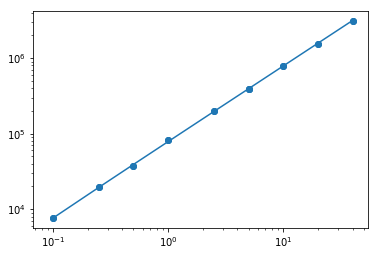

In [36]:
def calibrate(df):
    fit = sm.wls('area ~ concentration', data=df, weights=df.concentration**-2).fit()
    return (fit.params[0], fit.params[1])

_data = calibration_data.sort_index().loc[(slice(None),'glucose'),:]
_intercept, _slope = calibrate(_data)
plt.scatter(_data.concentration, _data.area)

xx = _data.concentration.sort_values().unique()
plt.plot(xx, _intercept + _slope * xx)
plt.xscale('log')
plt.yscale('log')

In [57]:
def calculate(signal, intercept, slope):
    return (signal - intercept) / slope

conc = (injection
          .join(peak)
          .join(known, on='known_id')
          .reset_index('molecule_id')
          .groupby('molecule_id')
          .apply(lambda df: calculate(df[df.fraction_known==0.0].area, *calibrate(df[df.fraction_known==1.0])))
          .T.fillna(0)
       )

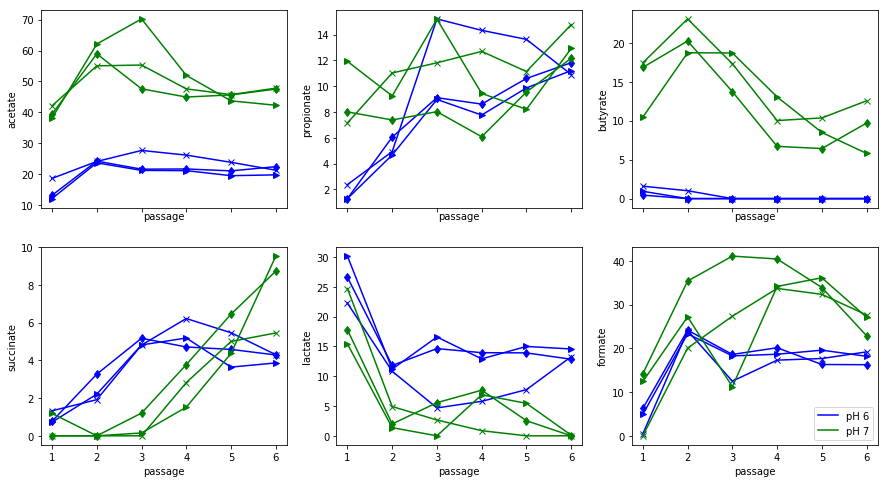

In [123]:
_data = (injection.join(sample, on='sample_id', how='right')
                  [['sample_id', 'lineage_id',
                    'ph', 'passage_number',
                    'passage_time']]
                  .join(conc)
                  [lambda x: x.passage_time == 24]
        )

marker_map = {'LIN-0001': 'x',
              'LIN-0002': '>',
              'LIN-0003': 'd',
              'LIN-0004': 'x',
              'LIN-0005': '>',
              'LIN-0006': 'd',}
color_map = {6: 'blue', 7: 'green'}
feat = 'butyrate'


fig, axs = plt.subplots(2, 3, figsize=(15, 8), sharex=True)
    
for molecule_id, ax in zip(['acetate', 'propionate', 'butyrate', 'succinate', 'lactate', 'formate'], axs.flatten()):
    ax.set_ylabel(molecule_id)
    ax.set_xlabel('passage')
    for ph, d0 in _data.groupby('ph'):
        for lineage_id, d1 in d0.groupby('lineage_id'):
            ax.plot('passage_number',
                     molecule_id,
                     data=d1.sort_values('passage_number'),
                     marker=marker_map[lineage_id], color=color_map[ph])

handles = [plt.plot([], [], color=color_map[ph], label='pH ' + str(ph))
           for ph in _data.ph.unique()]
ax.legend(handles=list(itertools.chain(*handles)))